## Import libraries

In [ ]:
!pip install rasterio dbfread

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 91.1 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import folium
import rasterio
from rasterio.plot import show
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LiPAD QC Data

## Load shapefile

File: ph137404000_fh5yr_30m_10m.shp (Data retrieved from LiPAD), source: https://lipad-fmc.dream.upd.edu.ph/layers/geonode%3Aph137404000_fh5yr_30m_10m

In [ ]:
# Read shapefile
gdf = gpd.read_file('/content/drive/MyDrive/PJDSC 2025/Data/Geospatial Flood/ph137404000_fh5yr_30m_10m.shp')

print(gdf.crs)
print(gdf.total_bounds)

EPSG:32651
[ 282480.1385 1612821.6278  300257.9594 1635573.5916]


In [ ]:
from dbfread import DBF
import os

# Read DBF file
dbf_path = '/content/drive/MyDrive/PJDSC 2025/Data/Geospatial Flood/ph137404000_fh5yr_30m_10m.dbf'

## Exploratory Data Analysis

In [ ]:
print(f"Shape: {gdf.shape}")
print(f"Columns: {gdf.columns.tolist()}")

print(f"\nGeometry types:")
print(gdf.geometry.type.value_counts())

print(f"\nSpatial bounds:")
print(gdf.total_bounds)

gdf.head()

Shape: (6, 3)
Columns: ['Var', 'Muncode', 'geometry']

Geometry types:
MultiPolygon    5
Polygon         1
Name: count, dtype: int64

Spatial bounds:
[ 282480.1385 1612821.6278  300257.9594 1635573.5916]

Missing values per column:
Var         0
Muncode     0
geometry    0
dtype: int64


Var      Muncode                                           geometry
0   -2  PH137404000  POLYGON ((299257.959 1634465.146, 299203.447 1...
1   -1  PH137404000  MULTIPOLYGON (((287825 1613625, 287825 1613615...
2    0  PH137404000  MULTIPOLYGON (((284298 1612821.628, 284278 161...
3    1  PH137404000  MULTIPOLYGON (((283248 1612821.628, 283238 161...
4    2  PH137404000  MULTIPOLYGON (((286648 1612821.628, 286638 161...

<Figure size 1200x800 with 0 Axes>

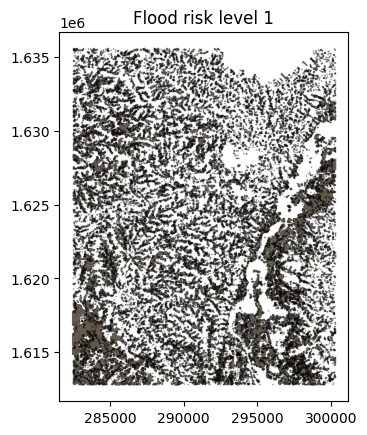

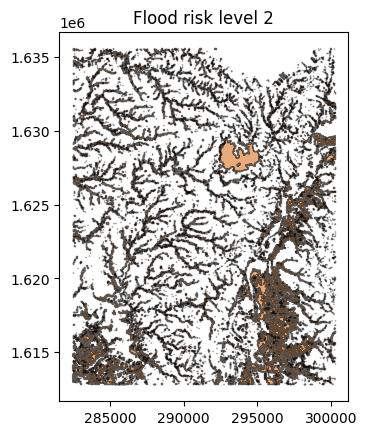

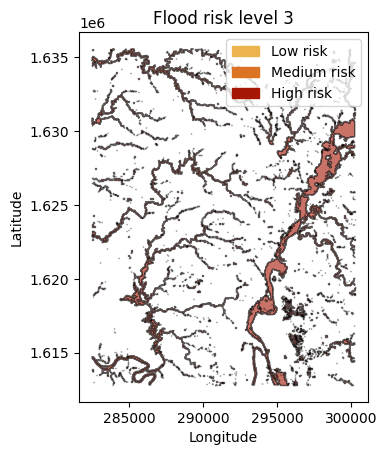

In [ ]:
# Label meanings
var_labels = {
    1: "Low risk",
    2: "Medium risk",
    3: "High risk"
}

risk_levels = [1,2,3]

palette = ['#EDB44D','#DC7322','#A51604']

color_map = {var: palette[i % len(palette)] for i, var in enumerate(risk_levels)}

plt.figure(figsize=(12, 8))

legend_handles = []

for var in risk_levels:
    color = color_map[var]
    gdf[gdf['Var'] == var].plot(alpha=0.6, edgecolor='black', color=color)
    plt.title(f"Flood risk level {var}")
    label = var_labels.get(var, f'Var = {var}')
    patch = mpatches.Patch(color=color, label=label)
    legend_handles.append(patch)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(handles=legend_handles)
plt.show()

## QC Boundary Data

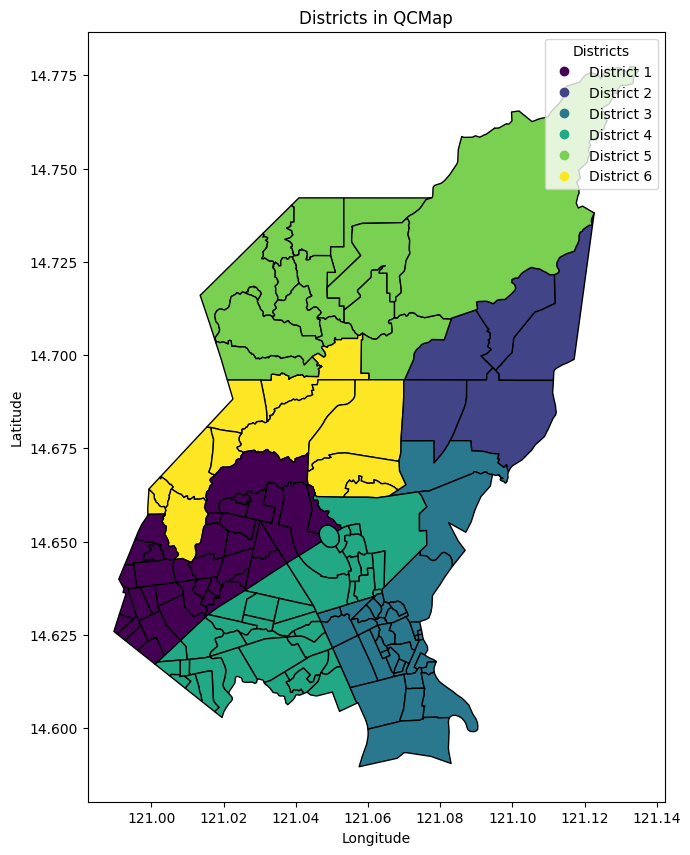

In [ ]:
gdf_qcmap = gpd.read_file('/content/drive/MyDrive/PJDSC 2025/Data/QCMap/QCMap_Edited.shp')

gdf_qcmap = gdf_qcmap.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(10, 10))
gdf_qcmap.plot(column='6_DISTRICT', ax=ax, cmap='viridis', edgecolor='black', legend=False)
plt.title('Districts in QCMap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

districts = ['1','2','3','4','5','6']
colors = plt.cm.viridis(np.linspace(0, 1, len(districts)))
for district, color in zip(districts, colors):
    ax.plot([], [], color=color, label=f'District {district}', linestyle='None', marker='o')

ax.legend(title='Districts')
plt.show()

In [ ]:
gdf_var3 = gdf[gdf['Var'] == 3].copy()

gdf_var3_geo = gdf_var3.to_crs(epsg=4326)
gdf_qcmap_geo = gdf_qcmap.to_crs(epsg=4326) # Define QC boundaries

# Only display high risk areas (Var = 3) within QC bounds
gdf_highrisk_qc = gpd.overlay(gdf_var3_geo, gdf_qcmap_geo, how='intersection', keep_geom_type=True)

if not gdf_qcmap_geo.empty:
    center = gdf_qcmap_geo.geometry.unary_union.centroid
    map_center = [center.y, center.x]
else:
    map_center = [14.65, 121.05] # Approximate center of Quezon City

m = folium.Map(location=map_center, zoom_start=12)

folium.GeoJson(
    gdf_qcmap_geo,
    name='Quezon City Boundary',
    style_function=lambda x: {'color': 'royalblue', 'fillOpacity': 0.1}
).add_to(m)

# High flood risk areas from QC
folium.GeoJson(
    gdf_highrisk_qc,
    name='High Flood Risk Areas within QC',
    style_function=lambda x: {'color': 'red', 'fillColor': 'red', 'fillOpacity': 0.5},
    tooltip=folium.features.GeoJsonTooltip(fields=['Var', '6_DISTRICT'], aliases=['Flood Risk:', 'QC District:'])

).add_to(m)

folium.LayerControl().add_to(m)

m

/tmp/ipython-input-3064196973.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = gdf_qcmap_geo.geometry.unary_union.centroid


In [ ]:
districts = [1,2,3,4,5,6]

high_risk_district_gdfs = {}

for district in districts:
    high_risk_district_gdfs[district] = gdf_highrisk_qc[gdf_highrisk_qc['6_DISTRICT'] == district]

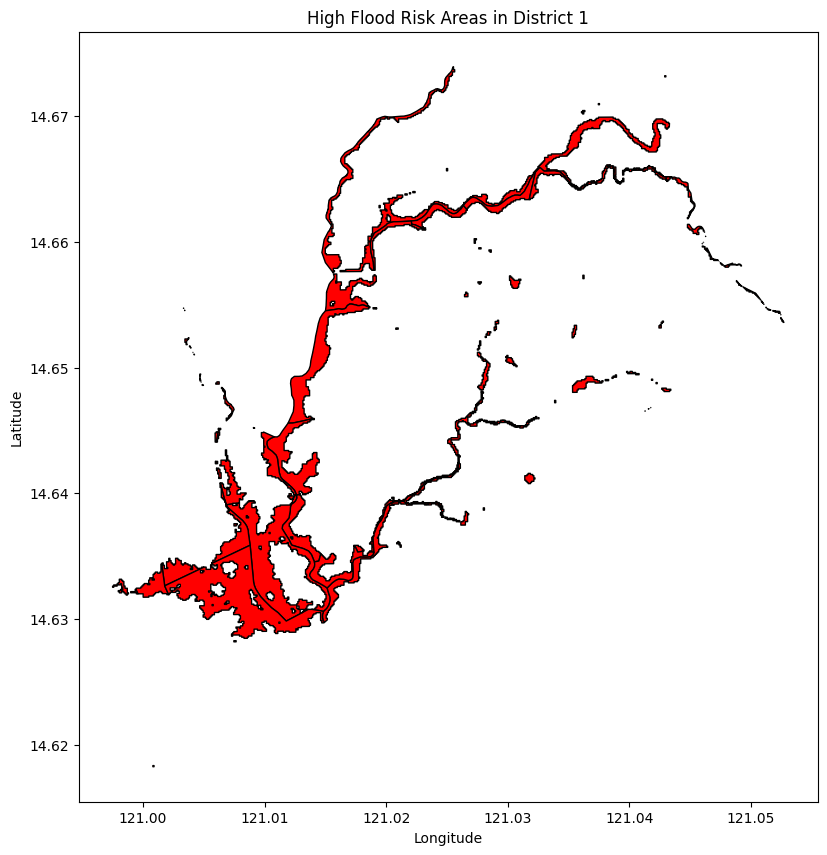

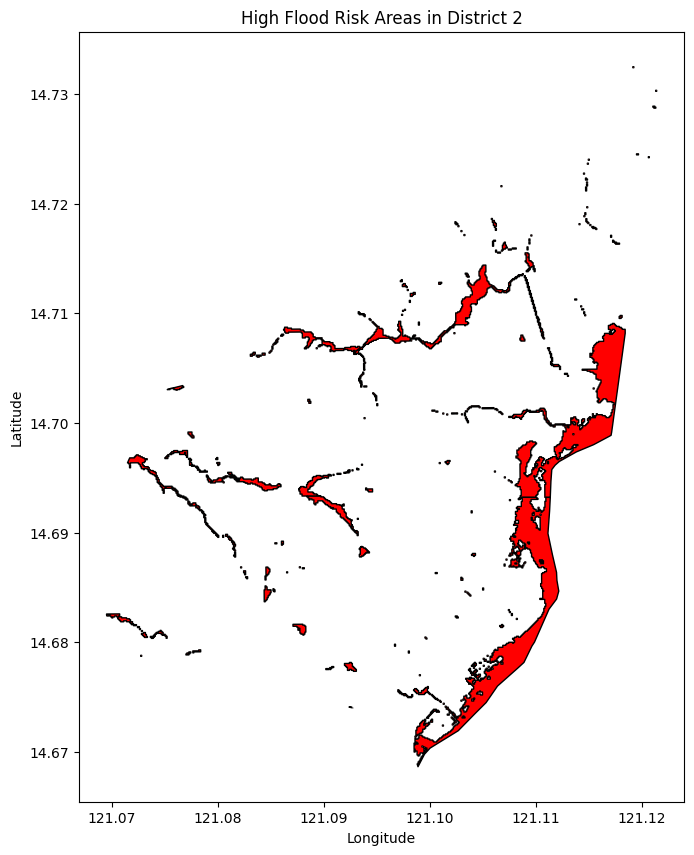

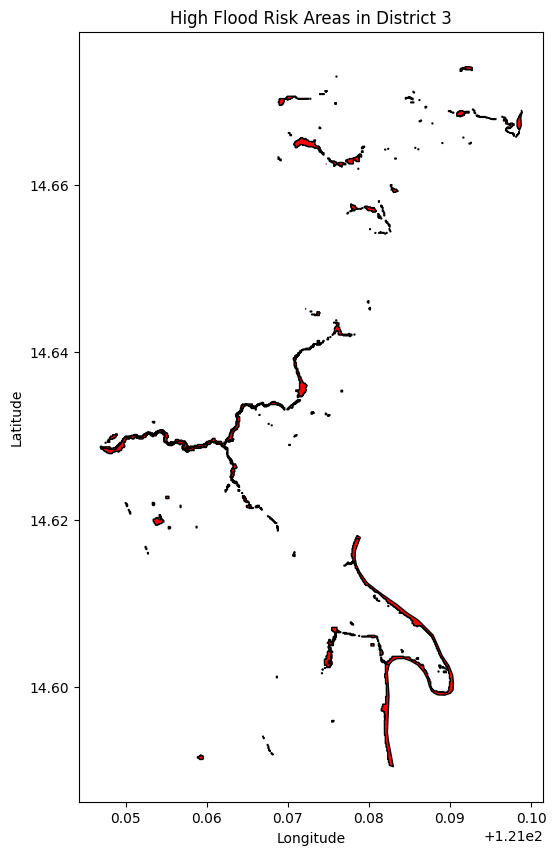

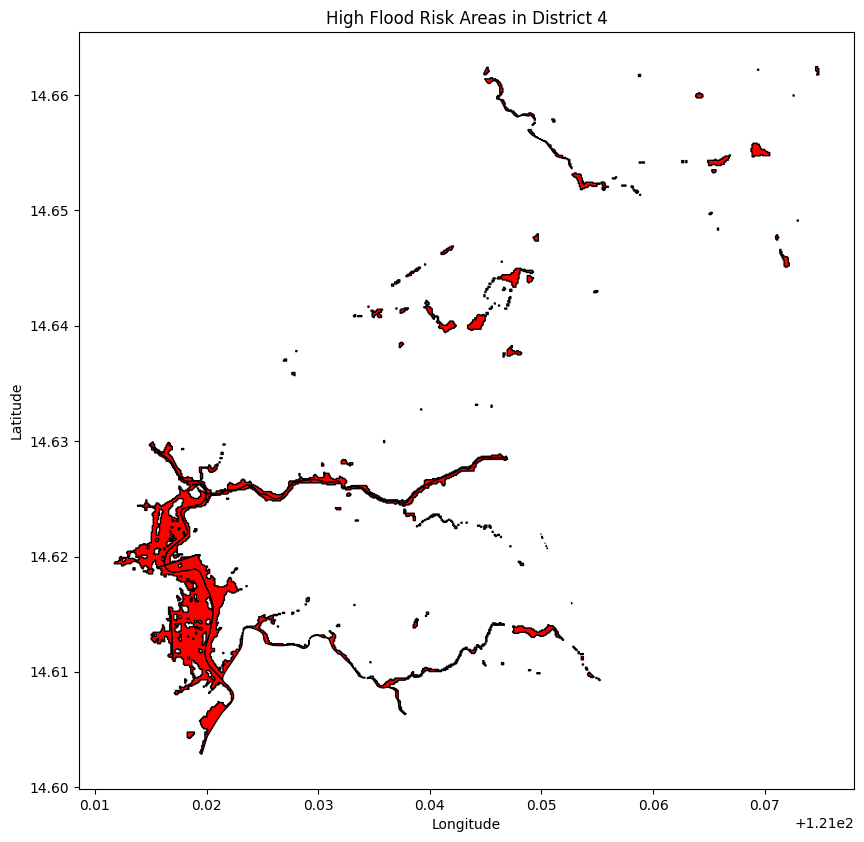

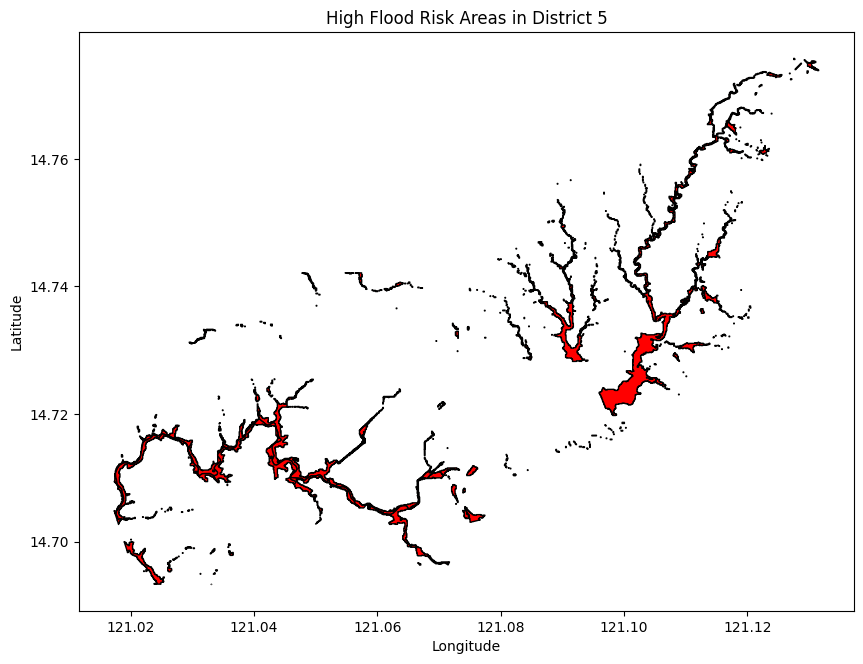

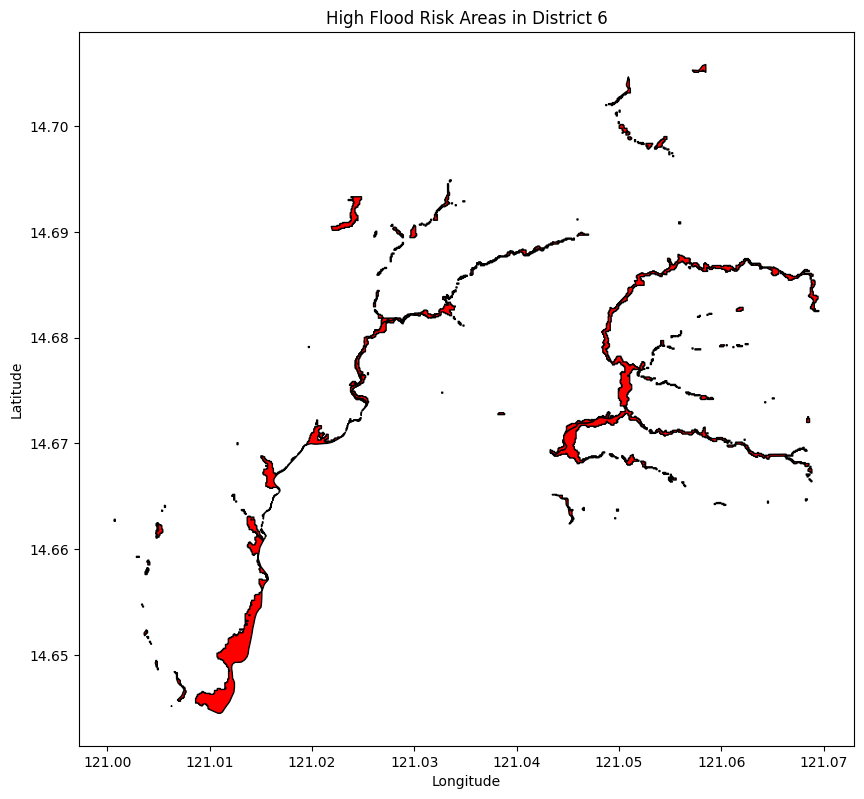

In [ ]:
for district in districts:
    gdf = high_risk_district_gdfs[district]
    if not gdf.empty:
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.plot(ax=ax, edgecolor='black', color='red')
        plt.title(f'High Flood Risk Areas in District {district}')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.show()
    else:
        print(f"No high-risk areas found for District {district}.")